In [1]:
print(sc.uiWebUrl)

http://midway3-0172.rcc.local:4041


In [2]:
! squeue -u yjia2

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41323339   caslake _interac    yjia2  R       6:00      1 midway3-0172


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/home/yjia2/fonts/NotoSansCJKsc-Regular.otf"  
fm.fontManager.addfont(font_path)
zh_font = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = zh_font.get_name()
plt.rcParams["axes.unicode_minus"] = False

from pyspark.sql import functions as F, types as T
from pyspark.ml.functions import vector_to_array
from pyspark.storagelevel import StorageLevel
from pyspark.ml.feature import Word2VecModel
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.feature import Word2Vec
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA

In [7]:
# Pre-processing

BASE_PATH = "cleaned_segmented_parquet"

df_raw = spark.read.parquet(BASE_PATH)

df = (
    df_raw
    .withColumnRenamed("文本内容_清洗", "content_cleaned")
    .withColumnRenamed("年份", "year")
    .select("content_cleaned", "year")
)

df = df.withColumn("year", F.col("year").cast("int"))

df = (
    df
    .withColumn("content_cleaned", F.trim(F.col("content_cleaned")))
    .filter(
        F.col("content_cleaned").isNotNull()
        & (F.length("content_cleaned") > 0)
    )
)

df = (
    df
    .withColumn("tokens", F.split(F.col("content_cleaned"), r"\s+"))
    .withColumn("tokens", F.expr("filter(tokens, x -> x <> '')"))
)

df = (
    df
    .withColumn("len_tokens", F.size("tokens"))
    .filter(F.col("len_tokens") >= 3)
    .drop("len_tokens")
)

year_stats = (
    df.groupBy("year")
      .agg(
          F.count("*").alias("n_docs"),
          F.sum(F.size("tokens")).alias("n_tokens")
      )
      .orderBy("year")
)

year_stats.show(1, truncate=False)


[Stage 14:=====================================================>(248 + 3) / 251]

+----+------+--------+
|year|n_docs|n_tokens|
+----+------+--------+
|1947|10769 |2711874 |
+----+------+--------+
only showing top 1 row



In [8]:
# Word2Vec hyper-parameters 
W2V_PARAMS = dict(
    vectorSize=150,
    windowSize=6,
    minCount=30,
    maxIter=3,          # epochs
    stepSize=0.025,     # learning rate
    numPartitions=100,
    maxSentenceLength=600,
    seed=42,
    inputCol="tokens",
    outputCol="w2v_features"
)

BASE_MODEL_DIR = "w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year"

In [9]:
years = (
    df.select("year")
      .distinct()
      .orderBy("year")
      .rdd.map(lambda r: r["year"])
      .collect()
)

print("Years to train:", years[:10], "... total =", len(years))

[Stage 24:>                                                         (0 + 1) / 1]

Years to train: [1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956] ... total = 78


In [10]:
MIN_DOCS = 500

for y in years:
    print(f"\n===== Training year {y} =====")

    df_y = (
        df.filter(F.col("year") == y)
          .select("tokens")
    )

    n_docs = df_y.count()
    print(f"Docs in {y} = {n_docs}")

    if n_docs < MIN_DOCS:
        print(f"Skip {y} (n_docs < MIN_DOCS={MIN_DOCS})")
        continue

    df_y_train = df_y.repartition(100).persist(StorageLevel.MEMORY_AND_DISK)
    _ = df_y_train.count()   
    print(f"{y}: cached training corpus")

    w2v = Word2Vec(**W2V_PARAMS)
    w2v_model = w2v.fit(df_y_train)
    print(f"{y}: model trained")

    df_y_train.unpersist()

    model_dir = f"{BASE_MODEL_DIR}/year={y}"
    print(f"{y}: saving model to {model_dir}")
    w2v_model.write().overwrite().save(model_dir)

    vecs = w2v_model.getVectors()   # DataFrame[word: string, vector: vector]
    vecs.write.mode("overwrite").parquet(f"{model_dir}/vectors_parquet")

    vocab_size = vecs.count()
    print(f"{y}: vocab_size = {vocab_size}")

print("\nAll yearly trainings done.")


===== Training year 1947 =====
Docs in 1947 = 10769


1947: cached training corpus


1947: model trained
1947: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1947


1947: vocab_size = 10630

===== Training year 1948 =====


Docs in 1948 = 8246


1948: cached training corpus


1948: model trained
1948: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1948
1948: vocab_size = 9372

===== Training year 1949 =====


Docs in 1949 = 18956


1949: cached training corpus


1949: model trained
1949: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1949
1949: vocab_size = 17189

===== Training year 1950 =====


Docs in 1950 = 19990


1950: cached training corpus


1950: model trained
1950: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1950
1950: vocab_size = 18651

===== Training year 1951 =====


Docs in 1951 = 13756


1951: cached training corpus


1951: model trained
1951: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1951
1951: vocab_size = 15638

===== Training year 1952 =====


Docs in 1952 = 13381


1952: cached training corpus


1952: model trained
1952: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1952
1952: vocab_size = 15649

===== Training year 1953 =====


Docs in 1953 = 12790


1953: cached training corpus


1953: model trained
1953: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1953
1953: vocab_size = 15426

===== Training year 1954 =====


Docs in 1954 = 13968


1954: cached training corpus


1954: model trained
1954: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1954
1954: vocab_size = 14829

===== Training year 1955 =====


Docs in 1955 = 15612


1955: cached training corpus


1955: model trained
1955: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1955
1955: vocab_size = 15561

===== Training year 1956 =====


Docs in 1956 = 23691


1956: cached training corpus


1956: model trained
1956: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1956
1956: vocab_size = 18127

===== Training year 1957 =====


Docs in 1957 = 25363


1957: cached training corpus


1957: model trained
1957: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1957
1957: vocab_size = 21444

===== Training year 1958 =====


Docs in 1958 = 28012


1958: cached training corpus


1958: model trained
1958: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1958
1958: vocab_size = 21781

===== Training year 1959 =====


Docs in 1959 = 22785


1959: cached training corpus


1959: model trained
1959: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1959
1959: vocab_size = 22565

===== Training year 1960 =====


Docs in 1960 = 23386


1960: cached training corpus


1960: model trained
1960: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1960
1960: vocab_size = 21979

===== Training year 1961 =====


Docs in 1961 = 21957


1961: cached training corpus


1961: model trained
1961: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1961
1961: vocab_size = 19853

===== Training year 1962 =====


Docs in 1962 = 17310


1962: cached training corpus


1962: model trained
1962: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1962
1962: vocab_size = 16279

===== Training year 1963 =====


Docs in 1963 = 15189


1963: cached training corpus


1963: model trained
1963: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1963
1963: vocab_size = 15311

===== Training year 1964 =====


Docs in 1964 = 16606


1964: cached training corpus


1964: model trained
1964: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1964
1964: vocab_size = 16595

===== Training year 1965 =====


Docs in 1965 = 16221


1965: cached training corpus


1965: model trained
1965: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1965
1965: vocab_size = 15970

===== Training year 1966 =====


Docs in 1966 = 12171


1966: cached training corpus


1966: model trained
1966: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1966
1966: vocab_size = 13148

===== Training year 1967 =====


Docs in 1967 = 9274


1967: cached training corpus


1967: model trained
1967: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1967
1967: vocab_size = 9744

===== Training year 1968 =====


Docs in 1968 = 9216


1968: cached training corpus


1968: model trained
1968: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1968
1968: vocab_size = 10021

===== Training year 1969 =====


Docs in 1969 = 10124


1969: cached training corpus


1969: model trained
1969: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1969
1969: vocab_size = 10851

===== Training year 1970 =====


Docs in 1970 = 10570


1970: cached training corpus


1970: model trained
1970: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1970
1970: vocab_size = 11448

===== Training year 1971 =====


Docs in 1971 = 10421


1971: cached training corpus


1971: model trained
1971: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1971
1971: vocab_size = 10916

===== Training year 1972 =====


Docs in 1972 = 14333


1972: cached training corpus


1972: model trained
1972: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1972
1972: vocab_size = 12454

===== Training year 1973 =====


Docs in 1973 = 14845


1973: cached training corpus


1973: model trained
1973: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1973
1973: vocab_size = 13151

===== Training year 1974 =====


Docs in 1974 = 12837


1974: cached training corpus


1974: model trained
1974: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1974
1974: vocab_size = 12942

===== Training year 1975 =====


Docs in 1975 = 13362


1975: cached training corpus


1975: model trained
1975: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1975
1975: vocab_size = 12445

===== Training year 1976 =====


Docs in 1976 = 12262


1976: cached training corpus


1976: model trained
1976: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1976
1976: vocab_size = 11610

===== Training year 1977 =====


Docs in 1977 = 12715


1977: cached training corpus


1977: model trained
1977: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1977
1977: vocab_size = 12849

===== Training year 1978 =====


Docs in 1978 = 13431


1978: cached training corpus


1978: model trained
1978: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1978
1978: vocab_size = 14525

===== Training year 1979 =====


Docs in 1979 = 17537


1979: cached training corpus


1979: model trained
1979: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1979
1979: vocab_size = 17176

===== Training year 1980 =====


Docs in 1980 = 27226


1980: cached training corpus


1980: model trained
1980: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1980
1980: vocab_size = 20371

===== Training year 1981 =====


Docs in 1981 = 28360


1981: cached training corpus


1981: model trained
1981: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1981
1981: vocab_size = 20841

===== Training year 1982 =====


Docs in 1982 = 28324


1982: cached training corpus


1982: model trained
1982: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1982
1982: vocab_size = 20705

===== Training year 1983 =====


Docs in 1983 = 31138


1983: cached training corpus


1983: model trained
1983: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1983
1983: vocab_size = 20278

===== Training year 1984 =====


Docs in 1984 = 31964


1984: cached training corpus


1984: model trained
1984: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1984
1984: vocab_size = 21164

===== Training year 1985 =====


Docs in 1985 = 34299


1985: cached training corpus


1985: model trained
1985: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1985
1985: vocab_size = 22854

===== Training year 1986 =====


Docs in 1986 = 33502


1986: cached training corpus


1986: model trained
1986: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1986
1986: vocab_size = 23095

===== Training year 1987 =====


Docs in 1987 = 32663


1987: cached training corpus


1987: model trained
1987: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1987
1987: vocab_size = 22589

===== Training year 1988 =====


Docs in 1988 = 33530


1988: cached training corpus


1988: model trained
1988: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1988
1988: vocab_size = 22579

===== Training year 1989 =====


Docs in 1989 = 30017


1989: cached training corpus


1989: model trained
1989: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1989
1989: vocab_size = 21810

===== Training year 1990 =====


Docs in 1990 = 31702


1990: cached training corpus


1990: model trained
1990: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1990
1990: vocab_size = 21883

===== Training year 1991 =====


Docs in 1991 = 33818


1991: cached training corpus


1991: model trained
1991: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1991
1991: vocab_size = 21012

===== Training year 1992 =====


Docs in 1992 = 37363


1992: cached training corpus


1992: model trained
1992: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1992
1992: vocab_size = 21540

===== Training year 1993 =====


Docs in 1993 = 36495


1993: cached training corpus


1993: model trained
1993: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1993
1993: vocab_size = 21416

===== Training year 1994 =====


Docs in 1994 = 33985


1994: cached training corpus


1994: model trained
1994: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1994
1994: vocab_size = 22984

===== Training year 1995 =====


Docs in 1995 = 37602


1995: cached training corpus


1995: model trained
1995: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1995
25/11/13 16:05:00 WARN TaskSetManager: Stage 1540 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
1995: vocab_size = 25984

===== Training year 1996 =====


Docs in 1996 = 37116


1996: cached training corpus


1996: model trained
1996: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1996
25/11/13 16:07:44 WARN TaskSetManager: Stage 1571 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.
1996: vocab_size = 25683

===== Training year 1997 =====


Docs in 1997 = 34310


1997: cached training corpus


1997: model trained
1997: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1997
25/11/13 16:10:15 WARN TaskSetManager: Stage 1602 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.
1997: vocab_size = 25806

===== Training year 1998 =====


Docs in 1998 = 33701


1998: cached training corpus


1998: model trained
1998: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1998
25/11/13 16:12:48 WARN TaskSetManager: Stage 1633 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
1998: vocab_size = 25987

===== Training year 1999 =====


Docs in 1999 = 34816


1999: cached training corpus


1999: model trained
1999: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=1999
25/11/13 16:15:33 WARN TaskSetManager: Stage 1664 contains a task of very large size (1037 KiB). The maximum recommended task size is 1000 KiB.
1999: vocab_size = 25434

===== Training year 2000 =====


Docs in 2000 = 34707


2000: cached training corpus


2000: model trained
2000: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2000
25/11/13 16:18:19 WARN TaskSetManager: Stage 1695 contains a task of very large size (1033 KiB). The maximum recommended task size is 1000 KiB.
2000: vocab_size = 25338

===== Training year 2001 =====


Docs in 2001 = 35614


2001: cached training corpus


2001: model trained
2001: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2001
25/11/13 16:20:55 WARN TaskSetManager: Stage 1726 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.
2001: vocab_size = 24989

===== Training year 2002 =====


Docs in 2002 = 34787


2002: cached training corpus


2002: model trained
2002: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2002
25/11/13 16:23:38 WARN TaskSetManager: Stage 1757 contains a task of very large size (1007 KiB). The maximum recommended task size is 1000 KiB.
2002: vocab_size = 24692

===== Training year 2003 =====


Docs in 2003 = 39173


2003: cached training corpus


2003: model trained
2003: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2003
25/11/13 16:27:03 WARN TaskSetManager: Stage 1788 contains a task of very large size (1198 KiB). The maximum recommended task size is 1000 KiB.
2003: vocab_size = 29406

===== Training year 2004 =====


Docs in 2004 = 38535


2004: cached training corpus


2004: model trained
2004: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2004
25/11/13 16:30:16 WARN TaskSetManager: Stage 1819 contains a task of very large size (1184 KiB). The maximum recommended task size is 1000 KiB.
2004: vocab_size = 29050

===== Training year 2005 =====


Docs in 2005 = 36653


2005: cached training corpus


2005: model trained
2005: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2005
25/11/13 16:33:49 WARN TaskSetManager: Stage 1850 contains a task of very large size (1168 KiB). The maximum recommended task size is 1000 KiB.
2005: vocab_size = 28664

===== Training year 2006 =====


Docs in 2006 = 36454


2006: cached training corpus


2006: model trained
2006: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2006
25/11/13 16:37:32 WARN TaskSetManager: Stage 1881 contains a task of very large size (1168 KiB). The maximum recommended task size is 1000 KiB.
2006: vocab_size = 28658

===== Training year 2007 =====


Docs in 2007 = 35574


2007: cached training corpus


2007: model trained
2007: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2007
25/11/13 16:40:36 WARN TaskSetManager: Stage 1912 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.
2007: vocab_size = 28285

===== Training year 2008 =====


Docs in 2008 = 32226


2008: cached training corpus


2008: model trained
2008: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2008
25/11/13 16:43:47 WARN TaskSetManager: Stage 1943 contains a task of very large size (1098 KiB). The maximum recommended task size is 1000 KiB.
2008: vocab_size = 26939

===== Training year 2009 =====


Docs in 2009 = 33795


2009: cached training corpus


2009: model trained
2009: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2009
25/11/13 16:47:57 WARN TaskSetManager: Stage 1974 contains a task of very large size (1175 KiB). The maximum recommended task size is 1000 KiB.
2009: vocab_size = 28802

===== Training year 2010 =====


Docs in 2010 = 42658


2010: cached training corpus


2010: model trained
2010: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2010
25/11/13 16:52:28 WARN TaskSetManager: Stage 2005 contains a task of very large size (1364 KiB). The maximum recommended task size is 1000 KiB.
2010: vocab_size = 33482

===== Training year 2011 =====


Docs in 2011 = 39661


2011: cached training corpus


2011: model trained
2011: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2011
25/11/13 16:57:40 WARN TaskSetManager: Stage 2036 contains a task of very large size (1402 KiB). The maximum recommended task size is 1000 KiB.
2011: vocab_size = 34427

===== Training year 2012 =====


Docs in 2012 = 37041


2012: cached training corpus


2012: model trained
2012: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2012
25/11/13 17:02:05 WARN TaskSetManager: Stage 2067 contains a task of very large size (1344 KiB). The maximum recommended task size is 1000 KiB.
2012: vocab_size = 32990

===== Training year 2013 =====


Docs in 2013 = 40442


2013: cached training corpus


2013: model trained
2013: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2013


25/11/13 17:07:12 WARN TaskSetManager: Stage 2098 contains a task of very large size (1440 KiB). The maximum recommended task size is 1000 KiB.
2013: vocab_size = 35342

===== Training year 2014 =====


Docs in 2014 = 40244


2014: cached training corpus


2014: model trained
2014: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2014
25/11/13 17:11:32 WARN TaskSetManager: Stage 2129 contains a task of very large size (1446 KiB). The maximum recommended task size is 1000 KiB.
2014: vocab_size = 35515

===== Training year 2015 =====


Docs in 2015 = 38856


2015: cached training corpus


2015: model trained
2015: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2015


25/11/13 17:16:11 WARN TaskSetManager: Stage 2160 contains a task of very large size (1439 KiB). The maximum recommended task size is 1000 KiB.
2015: vocab_size = 35304

===== Training year 2016 =====


Docs in 2016 = 37060


2016: cached training corpus


2016: model trained
2016: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2016
25/11/13 17:21:11 WARN TaskSetManager: Stage 2191 contains a task of very large size (1409 KiB). The maximum recommended task size is 1000 KiB.
2016: vocab_size = 34561

===== Training year 2017 =====


Docs in 2017 = 35296


2017: cached training corpus


2017: model trained
2017: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2017
25/11/13 17:25:46 WARN TaskSetManager: Stage 2222 contains a task of very large size (1347 KiB). The maximum recommended task size is 1000 KiB.
2017: vocab_size = 33087

===== Training year 2018 =====


Docs in 2018 = 33780


2018: cached training corpus


2018: model trained
2018: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2018
25/11/13 17:30:34 WARN TaskSetManager: Stage 2253 contains a task of very large size (1341 KiB). The maximum recommended task size is 1000 KiB.
2018: vocab_size = 32903

===== Training year 2019 =====


Docs in 2019 = 24557


2019: cached training corpus


2019: model trained
2019: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2019
25/11/13 17:33:53 WARN TaskSetManager: Stage 2284 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.
2019: vocab_size = 27564

===== Training year 2020 =====


Docs in 2020 = 25675


2020: cached training corpus


2020: model trained
2020: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2020
25/11/13 17:37:18 WARN TaskSetManager: Stage 2315 contains a task of very large size (1104 KiB). The maximum recommended task size is 1000 KiB.
2020: vocab_size = 27086

===== Training year 2021 =====


Docs in 2021 = 23474


2021: cached training corpus


2021: model trained
2021: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2021
25/11/13 17:40:51 WARN TaskSetManager: Stage 2346 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.
2021: vocab_size = 26239

===== Training year 2022 =====


Docs in 2022 = 22248


2022: cached training corpus


2022: model trained
2022: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2022
2022: vocab_size = 24397

===== Training year 2023 =====


Docs in 2023 = 24397


2023: cached training corpus


2023: model trained
2023: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2023
25/11/13 17:47:42 WARN TaskSetManager: Stage 2408 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.
2023: vocab_size = 26018

===== Training year 2024 =====


Docs in 2024 = 17096


2024: cached training corpus


2024: model trained
2024: saving model to w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year/year=2024
2024: vocab_size = 19852

All yearly trainings done.


In [12]:
from pyspark.ml.feature import Word2VecModel

BASE_MODEL_DIR = "w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year"

def show_neighbors_for_year(year: int, word: str, topn: int = 20):
    """
    Load the yearly Word2Vec model and show nearest neighbors for a given word.
    """
    model_path = f"{BASE_MODEL_DIR}/year={year}"
    print(f"\n=== Year {year} | word = {word} ===")

    # Load model
    w2v_model = Word2VecModel.load(model_path)

    # Check if the word exists first (avoid errors)
    vecs = w2v_model.getVectors()
    if vecs.filter(F.col("word") == word).limit(1).count() == 0:
        print(f"'{word}' not in vocabulary for year {year}.")
        return

    # Show nearest neighbors
    syn = w2v_model.findSynonyms(word, topn)
    syn.show(truncate=False)

# Example: check a few years
for y in [1950, 1978, 1992, 2008, 2018]:
    show_neighbors_for_year(y, "人民", topn=15)



=== Year 1950 | word = 人民 ===


+--------+-------------------+
|word    |similarity         |
+--------+-------------------+
|万众一心|0.5745235085487366 |
|正义事业|0.5567136406898499 |
|自由民主|0.5509663820266724 |
|死敌    |0.5310417413711548 |
|人民意志|0.5274190306663513 |
|正义    |0.5226737260818481 |
|各族人民|0.5216115117073059 |
|英勇斗争|0.5147422552108765 |
|不可动摇|0.5076724290847778 |
|爱好和平|0.5045686960220337 |
|正义战争|0.5042296051979065 |
|解放事业|0.5029891133308411 |
|深信    |0.5010573863983154 |
|坚信    |0.49985629320144653|
|亿万人民|0.49916237592697144|
+--------+-------------------+


=== Year 1978 | word = 人民 ===
+--------+------------------+
|word    |similarity        |
+--------+------------------+
|正义事业|0.6518587470054626|
|同情    |0.5929450988769531|
|始终不渝|0.5833016633987427|
|解放事业|0.5722860097885132|
|珍视    |0.5614731907844543|
|声援    |0.5534377098083496|
|愿望    |0.5524501800537109|
|正义    |0.5487756133079529|
|正义斗争|0.5425110459327698|
|衷心祝愿|0.5412216186523438|
|昌盛    |0.5387455224990845|
|民族解放|0.5379835963249207|
|坚信    |0.5296506

In [37]:
from pyspark.ml.feature import Word2VecModel
from pyspark.sql import functions as F
from pyspark.sql import Row

import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.neighbors import NearestNeighbors

# ---------- Config ----------
BASE_MODEL_DIR = "w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year"
N2V_OUT_BASE = "node2vec_embeddings_concept"   # where to save node2vec results

# 你关心的“政治核心概念”（可以随时增删）
SEED_WORDS = [
    # --- A. 主体/人民/群众 ---
    "人民", "群众", "工人", "农民", "干部", "青年", "妇女", "知识分子",
    
    # --- B. 国家/政府/政党 ---
    "国家", "政府", "中央", "地方", "党", "党委", "政府部门", "社会组织",
    "领导", "干部", "党员", "代表", "委员",

    # --- C. 政治秩序/制度 ---
    "制度", "体制", "政策", "方针", "路线", "改革", "开放", "现代化",
    "社会主义", "共产主义", "集体主义",

    # --- D. 治理/管理/能力 ---
    "治理", "治理能力", "治理体系", "管理", "监督", "问责", "服务",
    "执行", "决策", "协调", "保障",

    # --- E. 法治与权利 ---
    "法治", "法律", "法规", "宪法", "权利", "权益", "秩序", "公平",
    "正义", "司法", "制度建设",

    # --- F. 经济建设/发展 ---
    "发展", "经济", "市场", "改革", "创新", "科技", "产业", "企业",
    "投资", "生产", "劳动", "分配",

    # --- G. 社会建设 ---
    "社会", "民生", "就业", "教育", "医疗", "住房", "文化",
    "公共服务", "社区", "和谐", "文明",

    # --- H. 安全稳定与国家利益 ---
    "安全", "稳定", "国家利益", "民族", "主权", "统一",
    "治安", "防范", "风险", "危机",

    # --- I. 阶层与社会结构 ---
    "阶级", "阶层", "工农联盟", "资产阶级", "无产阶级",
    "小康", "贫困", "脱贫", "共同富裕",

    # --- J. 意识形态词汇 ---
    "思想", "意识形态", "理论", "路线", "精神", "价值观",
    "马克思主义", "毛泽东思想", "中国特色社会主义",

    # --- K. 外交/国际关系（可选） ---
    "国际", "和平", "合作", "发展权", "全球化", "多边", "外交",

    # --- L. 时代主题类（跨年出现） ---
    "奋斗", "责任", "使命", "改革精神", "创新精神", "奉献"
]

# ---------- Hyper-parameters ----------
TOPN_PER_SEED = 45        # 每个种子词在 W2V 中取多少邻居
MIN_SIM_THRESHOLD = 0.30  # W2V 相似度下限，用来过滤邻居

K_NEIGHBORS = 10          # 语义图中每个词连接的近邻数量
GRAPH_SIM_THRESHOLD = 0.35  # 图中边的相似度阈值

NODE2VEC_DIM = 128
NODE2VEC_WALK_LENGTH = 40
NODE2VEC_NUM_WALKS = 10
NODE2VEC_WINDOW = 10

# 最小图规模，小于这个就跳过（年份太 sparse）
MIN_GRAPH_NODES = 20


In [38]:
def build_concept_vocab_for_year(year: int):
    """
    For a given year, build a concept-focused vocabulary:
      - start from SEED_WORDS
      - for each seed, take its top-N nearest neighbors in that year's Word2Vec
      - union all seeds + neighbors into a vocab set

    Returns:
        vocab_list: sorted list of unique words
    """
    model_path = f"{BASE_MODEL_DIR}/year={year}"

    # Load yearly Word2Vec model
    w2v_model = Word2VecModel.load(model_path)
    vecs_df = w2v_model.getVectors()

    # Seeds that exist in this year's vocab
    seed_exist = (
        vecs_df
        .filter(F.col("word").isin(SEED_WORDS))
        .select("word")
        .rdd.map(lambda r: r["word"])
        .collect()
    )

    vocab_set = set(seed_exist)

    # For each seed, get top-N similar words
    for seed in seed_exist:
        syn_df = w2v_model.findSynonyms(seed, TOPN_PER_SEED)

        if MIN_SIM_THRESHOLD is not None:
            syn_df = syn_df.filter(F.col("similarity") >= MIN_SIM_THRESHOLD)

        neighbors = syn_df.select("word").rdd.map(lambda r: r["word"]).collect()
        vocab_set.update(neighbors)

    vocab_list = sorted(vocab_set)
    return vocab_list

In [39]:
def build_semantic_graph_for_year(year: int, vocab_list):
    """
    Given a year and a concept-focused vocab list:
      1. Load that year's Word2Vec model
      2. Filter vectors to only words in vocab_list
      3. Build a k-NN semantic graph based on cosine similarity

    Returns:
        G: networkx.Graph
        words: list of words actually present in this year's Word2Vec vocab
    """
    model_path = f"{BASE_MODEL_DIR}/year={year}"

    # Load Word2Vec vectors
    w2v_model = Word2VecModel.load(model_path)
    vecs_df = w2v_model.getVectors()

    # Filter to concept vocab
    vecs_filtered = (
        vecs_df
        .filter(F.col("word").isin(vocab_list))
        .select("word", "vector")
    )

    rows = vecs_filtered.collect()
    if len(rows) < MIN_GRAPH_NODES:
        return None, []

    words = [row["word"] for row in rows]
    vectors = np.vstack([np.array(row["vector"]) for row in rows])

    # Normalize for cosine similarity
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    vectors_norm = vectors / np.clip(norms, 1e-9, None)

    # k-NN model (cosine distance)
    k_eff = min(K_NEIGHBORS + 1, len(words))
    nn = NearestNeighbors(
        n_neighbors=k_eff,
        metric='cosine',
        n_jobs=-1
    )
    nn.fit(vectors_norm)
    distances, indices = nn.kneighbors(vectors_norm)

    # Build graph
    G = nx.Graph()
    for w in words:
        G.add_node(w)

    N = len(words)
    for i in range(N):
        src_word = words[i]
        for j in range(1, k_eff):  # skip itself
            nbr_idx = indices[i, j]
            dst_word = words[nbr_idx]
            sim = 1.0 - distances[i, j]

            if sim < GRAPH_SIM_THRESHOLD:
                continue

            if G.has_edge(src_word, dst_word):
                if sim > G[src_word][dst_word]['weight']:
                    G[src_word][dst_word]['weight'] = sim
            else:
                G.add_edge(src_word, dst_word, weight=sim)

    return G, words


In [40]:
def run_node2vec_for_year(G, year: int):
    """
    Run Node2Vec on a given semantic graph G for a specific year.
      1) Learn node embeddings
      2) Save embeddings as a Spark DataFrame to Parquet

    Returns:
        n2v_model: trained node2vec model
        n2v_df: Spark DataFrame[word, n2v_vector]
    """
    if G is None or G.number_of_nodes() == 0:
        return None, None

    # Train Node2Vec model
    node2vec = Node2Vec(
        G,
        dimensions=NODE2VEC_DIM,
        walk_length=NODE2VEC_WALK_LENGTH,
        num_walks=NODE2VEC_NUM_WALKS,
        weight_key='weight',
        workers=4
    )

    n2v_model = node2vec.fit(
        window=NODE2VEC_WINDOW,
        min_count=1,
        batch_words=32
    )

    # Convert to Spark DataFrame
    rows = []
    for node in G.nodes():
        vec = n2v_model.wv[node].tolist()
        rows.append(Row(word=node, n2v_vector=vec))

    n2v_df = spark.createDataFrame(rows)

    # Save to Parquet
    out_path = f"{N2V_OUT_BASE}/year={year}"
    n2v_df.write.mode("overwrite").parquet(out_path)

    return n2v_model, n2v_df

In [42]:
years = (
    df.select("year")
      .distinct()
      .orderBy("year")
      .rdd.map(lambda r: r["year"])
      .collect()
)

print(years[:20])


[1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966]


In [43]:
for year in years:
    print("\n" + "="*60)
    print(f"########## YEAR {year} ##########")

    # Step 1: concept vocab
    try:
        vocab_year = build_concept_vocab_for_year(year)
    except Exception as e:
        print(f"[Year {year}] Failed to build vocab ({e}). Skip this year.")
        continue

    # Step 2: semantic graph
    G_year, words_year = build_semantic_graph_for_year(year, vocab_year)
    if G_year is None or G_year.number_of_nodes() < MIN_GRAPH_NODES:
        print(f"[Year {year}] Graph too small or None. Skip Node2Vec.")
        continue

    # Step 3: Node2Vec
    try:
        run_node2vec_for_year(G_year, year)
    except Exception as e:
        print(f"[Year {year}] Node2Vec failed ({e}). Skip.")
        continue



########## YEAR 1947 ##########


Computing transition probabilities:   0%|          | 0/1907 [00:00<?, ?it/s]

/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/site-packages/google/rpc/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/site-packages/google/rpc/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/site-packages/google/rpc/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early 


########## YEAR 1948 ##########


Computing transition probabilities:   0%|          | 0/2013 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]



########## YEAR 1949 ##########


Computing transition probabilities:   0%|          | 0/2570 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]



########## YEAR 1950 ##########


Computing transition probabilities:   0%|          | 0/2790 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]



########## YEAR 1951 ##########


Computing transition probabilities:   0%|          | 0/2710 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]



########## YEAR 1952 ##########


Computing transition probabilities:   0%|          | 0/2710 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]



########## YEAR 1953 ##########


Computing transition probabilities:   0%|          | 0/2626 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]



########## YEAR 1954 ##########


Computing transition probabilities:   0%|          | 0/2659 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]



########## YEAR 1955 ##########


Computing transition probabilities:   0%|          | 0/2640 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]



########## YEAR 1956 ##########


Computing transition probabilities:   0%|          | 0/2702 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]



########## YEAR 1957 ##########


Computing transition probabilities:   0%|          | 0/3001 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]



########## YEAR 1958 ##########


Computing transition probabilities:   0%|          | 0/2783 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]



########## YEAR 1959 ##########


Computing transition probabilities:   0%|          | 0/2882 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]



########## YEAR 1960 ##########


Computing transition probabilities:   0%|          | 0/2918 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]



########## YEAR 1961 ##########


Computing transition probabilities:   0%|          | 0/2725 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]



########## YEAR 1962 ##########


Computing transition probabilities:   0%|          | 0/2578 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]



########## YEAR 1963 ##########


Computing transition probabilities:   0%|          | 0/2654 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]



########## YEAR 1964 ##########


Computing transition probabilities:   0%|          | 0/2824 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]



########## YEAR 1965 ##########


Computing transition probabilities:   0%|          | 0/2790 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]



########## YEAR 1966 ##########


Computing transition probabilities:   0%|          | 0/2665 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]



########## YEAR 1967 ##########


Computing transition probabilities:   0%|          | 0/2516 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]



########## YEAR 1968 ##########


Computing transition probabilities:   0%|          | 0/2504 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]



########## YEAR 1969 ##########


Computing transition probabilities:   0%|          | 0/2737 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]



########## YEAR 1970 ##########


Computing transition probabilities:   0%|          | 0/2561 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]



########## YEAR 1971 ##########


Computing transition probabilities:   0%|          | 0/2559 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]



########## YEAR 1972 ##########


Computing transition probabilities:   0%|          | 0/2547 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]



########## YEAR 1973 ##########


Computing transition probabilities:   0%|          | 0/2698 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]



########## YEAR 1974 ##########


Computing transition probabilities:   0%|          | 0/2790 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]



########## YEAR 1975 ##########


Computing transition probabilities:   0%|          | 0/2636 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]



########## YEAR 1976 ##########


Computing transition probabilities:   0%|          | 0/2556 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]



########## YEAR 1977 ##########


Computing transition probabilities:   0%|          | 0/2660 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]



########## YEAR 1978 ##########


Computing transition probabilities:   0%|          | 0/2651 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]



########## YEAR 1979 ##########


Computing transition probabilities:   0%|          | 0/2758 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]



########## YEAR 1980 ##########


Computing transition probabilities:   0%|          | 0/2937 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]



########## YEAR 1981 ##########


Computing transition probabilities:   0%|          | 0/2900 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]



########## YEAR 1982 ##########


Computing transition probabilities:   0%|          | 0/2974 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]



########## YEAR 1983 ##########


Computing transition probabilities:   0%|          | 0/2887 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]



########## YEAR 1984 ##########


Computing transition probabilities:   0%|          | 0/2934 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]



########## YEAR 1985 ##########


Computing transition probabilities:   0%|          | 0/2941 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]



########## YEAR 1986 ##########


Computing transition probabilities:   0%|          | 0/2982 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]



########## YEAR 1987 ##########


Computing transition probabilities:   0%|          | 0/2953 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]



########## YEAR 1988 ##########


Computing transition probabilities:   0%|          | 0/3011 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]



########## YEAR 1989 ##########


Computing transition probabilities:   0%|          | 0/2981 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]



########## YEAR 1990 ##########


Computing transition probabilities:   0%|          | 0/3001 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]



########## YEAR 1991 ##########


Computing transition probabilities:   0%|          | 0/3043 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]



########## YEAR 1992 ##########


Computing transition probabilities:   0%|          | 0/3048 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]



########## YEAR 1993 ##########


Computing transition probabilities:   0%|          | 0/3095 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]



########## YEAR 1994 ##########


Computing transition probabilities:   0%|          | 0/3079 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]



########## YEAR 1995 ##########


Computing transition probabilities:   0%|          | 0/3189 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]



########## YEAR 1996 ##########


Computing transition probabilities:   0%|          | 0/3217 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]



########## YEAR 1997 ##########


Computing transition probabilities:   0%|          | 0/3223 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]



########## YEAR 1998 ##########


Computing transition probabilities:   0%|          | 0/3244 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



########## YEAR 1999 ##########


Computing transition probabilities:   0%|          | 0/3214 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]



########## YEAR 2000 ##########


Computing transition probabilities:   0%|          | 0/3218 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]



########## YEAR 2001 ##########


Computing transition probabilities:   0%|          | 0/3289 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



########## YEAR 2002 ##########


Computing transition probabilities:   0%|          | 0/3235 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]



########## YEAR 2003 ##########


Computing transition probabilities:   0%|          | 0/3270 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



########## YEAR 2004 ##########


Computing transition probabilities:   0%|          | 0/3256 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



########## YEAR 2005 ##########


Computing transition probabilities:   0%|          | 0/3261 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



########## YEAR 2006 ##########


Computing transition probabilities:   0%|          | 0/3287 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



########## YEAR 2007 ##########


Computing transition probabilities:   0%|          | 0/3293 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



########## YEAR 2008 ##########


Computing transition probabilities:   0%|          | 0/3310 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



########## YEAR 2009 ##########


Computing transition probabilities:   0%|          | 0/3344 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



########## YEAR 2010 ##########


Computing transition probabilities:   0%|          | 0/3400 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



########## YEAR 2011 ##########


Computing transition probabilities:   0%|          | 0/3386 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]



########## YEAR 2012 ##########


Computing transition probabilities:   0%|          | 0/3492 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]



########## YEAR 2013 ##########


Computing transition probabilities:   0%|          | 0/3393 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



########## YEAR 2014 ##########


Computing transition probabilities:   0%|          | 0/3468 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]



########## YEAR 2015 ##########


Computing transition probabilities:   0%|          | 0/3466 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]



########## YEAR 2016 ##########


Computing transition probabilities:   0%|          | 0/3433 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]



########## YEAR 2017 ##########


Computing transition probabilities:   0%|          | 0/3394 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



########## YEAR 2018 ##########


Computing transition probabilities:   0%|          | 0/3400 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



########## YEAR 2019 ##########


Computing transition probabilities:   0%|          | 0/3371 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



########## YEAR 2020 ##########


Computing transition probabilities:   0%|          | 0/3358 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



########## YEAR 2021 ##########


Computing transition probabilities:   0%|          | 0/3533 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



########## YEAR 2022 ##########


Computing transition probabilities:   0%|          | 0/3373 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]



########## YEAR 2023 ##########


Computing transition probabilities:   0%|          | 0/3393 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



########## YEAR 2024 ##########


Computing transition probabilities:   0%|          | 0/3036 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


In [44]:
def load_n2v_year(year):
    path = f"node2vec_embeddings_concept/year={year}"
    df = spark.read.parquet(path)
    # convert to python dict: word → vector(list)
    emb = {row["word"]: row["n2v_vector"] for row in df.collect()}
    return emb


In [45]:
import numpy as np

def top_neighbors(emb_dict, target, topk=20):
    if target not in emb_dict:
        print(f"'{target}' not in vocab.")
        return []

    target_vec = np.array(emb_dict[target])
    target_norm = target_vec / np.linalg.norm(target_vec)

    words = []
    vecs = []
    for w, v in emb_dict.items():
        words.append(w)
        vecs.append(v)

    vecs = np.array(vecs)
    norms = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

    sims = norms @ target_norm
    idx = np.argsort(-sims)[:topk]

    return [(words[i], float(sims[i])) for i in idx]


In [46]:
years_to_check = [1950, 1965, 1978, 1992, 2000, 2010, 2020]


In [47]:
for y in years_to_check:
    emb = load_n2v_year(y)
    print(f"\n==== {y} ====")
    neigh = top_neighbors(emb, "人民", topk=15)
    for w, s in neigh:
        print(f"{w}\t{s:.4f}")



==== 1950 ====
人民	1.0000
人民意志	0.7775
深信	0.7639
正义	0.7588
万众一心	0.7546
自由民主	0.7409
四亿七千五百万	0.7348
义愤	0.7342
死敌	0.7331
全世界	0.7323
英勇斗争	0.7312
反侵略	0.7309
爱好和平	0.7211
确信	0.7173
正义事业	0.7149

==== 1965 ====
人民	1.0000
全力支持	0.9147
无保留地	0.8976
正义斗争	0.8968
强有力	0.8928
兄弟姐妹	0.8751
后盾	0.8730
正义事业	0.8643
同情	0.8613
正义	0.8481
誓作	0.8472
声援	0.8468
坚定不移	0.8446
英勇斗争	0.8407
全世界	0.8370

==== 1978 ====
人民	1.0000
同情	0.8543
正义事业	0.8439
被压迫	0.8237
珍视	0.8169
深情厚谊	0.8155
声援	0.8104
情谊	0.8078
解放事业	0.8057
赢得	0.8055
一如既往	0.7994
正义斗争	0.7951
民族解放	0.7842
兄弟	0.7827
互相支持	0.7800

==== 1992 ====
人民	1.0000
共命运	0.7638
怀有	0.7427
爱戴	0.7370
情谊	0.7331
勤劳	0.7061
深厚	0.6967
各族人民	0.6937
息息相关	0.6922
幸福	0.6902
拥护	0.6890
血肉	0.6890
中来	0.6855
安居乐业	0.6777
愿望	0.6758

==== 2000 ====
人民	1.0000
拥护	0.8137
血肉	0.7982
谋利益	0.7887
深厚感情	0.7820
依靠人民	0.7746
真心	0.7696
归宿	0.7669
党和政府	0.7534
地为	0.7337
民主专政	0.7212
各族人民	0.7127
放在心上	0.6973
全心全意	0.6948
根本利益	0.6914

==== 2010 ====
人民	1.0000
同呼吸	0.8251
心连心	0.8234
深厚感情	0.8202
血肉	0.8181
共命运	0.8061
深情厚谊	0.7949
真切感

In [49]:
import numpy as np

def load_n2v_year(year):
    path = f"node2vec_embeddings_concept/year={year}"
    df = spark.read.parquet(path)
    emb = {row["word"]: row["n2v_vector"] for row in df.collect()}
    return emb


In [50]:
def top_neighbors(emb_dict, target, topk=20):
    if target not in emb_dict:
        return []

    target_vec = np.array(emb_dict[target])
    target_norm = target_vec / np.linalg.norm(target_vec)

    words = []
    vecs = []
    for w, v in emb_dict.items():
        words.append(w)
        vecs.append(v)

    vecs = np.array(vecs)
    norms = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

    sims = norms @ target_norm
    idx = np.argsort(-sims)[:topk]

    return [(words[i], float(sims[i])) for i in idx]


In [51]:
import pandas as pd

TARGET_WORD = "人民"
TOPK = 20

# 你已经有 df，直接从里面拿年份：
years = (
    df.select("year")
      .distinct()
      .orderBy("year")
      .rdd.map(lambda r: r["year"])
      .collect()
)

rows = []

for y in years:
    emb = load_n2v_year(y)
    neighbors = top_neighbors(emb, TARGET_WORD, topk=TOPK)

    if not neighbors:
        # 这一年 vocab 里没有“人民”，就跳过
        continue

    for rank, (w, sim) in enumerate(neighbors, start=1):
        rows.append({
            "year": y,
            "rank": rank,
            "neighbor": w,
            "similarity": sim
        })

# 放进 pandas DataFrame
neighbors_df = pd.DataFrame(rows).sort_values(["year", "rank"])

# 看一眼前几行
print(neighbors_df.head(30))

# 存成 CSV（保存在当前工作目录）
neighbors_df.to_csv("renmin_neighbors_node2vec.csv", index=False)


    year  rank neighbor  similarity
0   1947     1       人民    1.000000
1   1947     2      千百万    0.815672
2   1947     3     生命财产    0.814684
3   1947     4       而战    0.803654
4   1947     5       本军    0.789779
5   1947     6     民主自由    0.772509
6   1947     7       同胞    0.757895
7   1947     8     奋斗到底    0.757274
8   1947     9       祖国    0.746848
9   1947    10       热望    0.744432
10  1947    11     新闻事业    0.738587
11  1947    12     幸福生活    0.735548
12  1947    13     民主运动    0.733831
13  1947    14       灾难    0.732090
14  1947    15       万岁    0.728592
15  1947    16     解放事业    0.724215
16  1947    17     滔天罪行    0.716230
17  1947    18       神圣    0.714377
18  1947    19       衷心    0.713235
19  1947    20     中华民族    0.711370
20  1948     1       人民    1.000000
21  1948     2       地为    0.729957
22  1948     3      爱国者    0.722285
23  1948     4       意志    0.717773
24  1948     5       爱国    0.716623
25  1948     6       坚信    0.715227
26  1948     7     民主自由    0

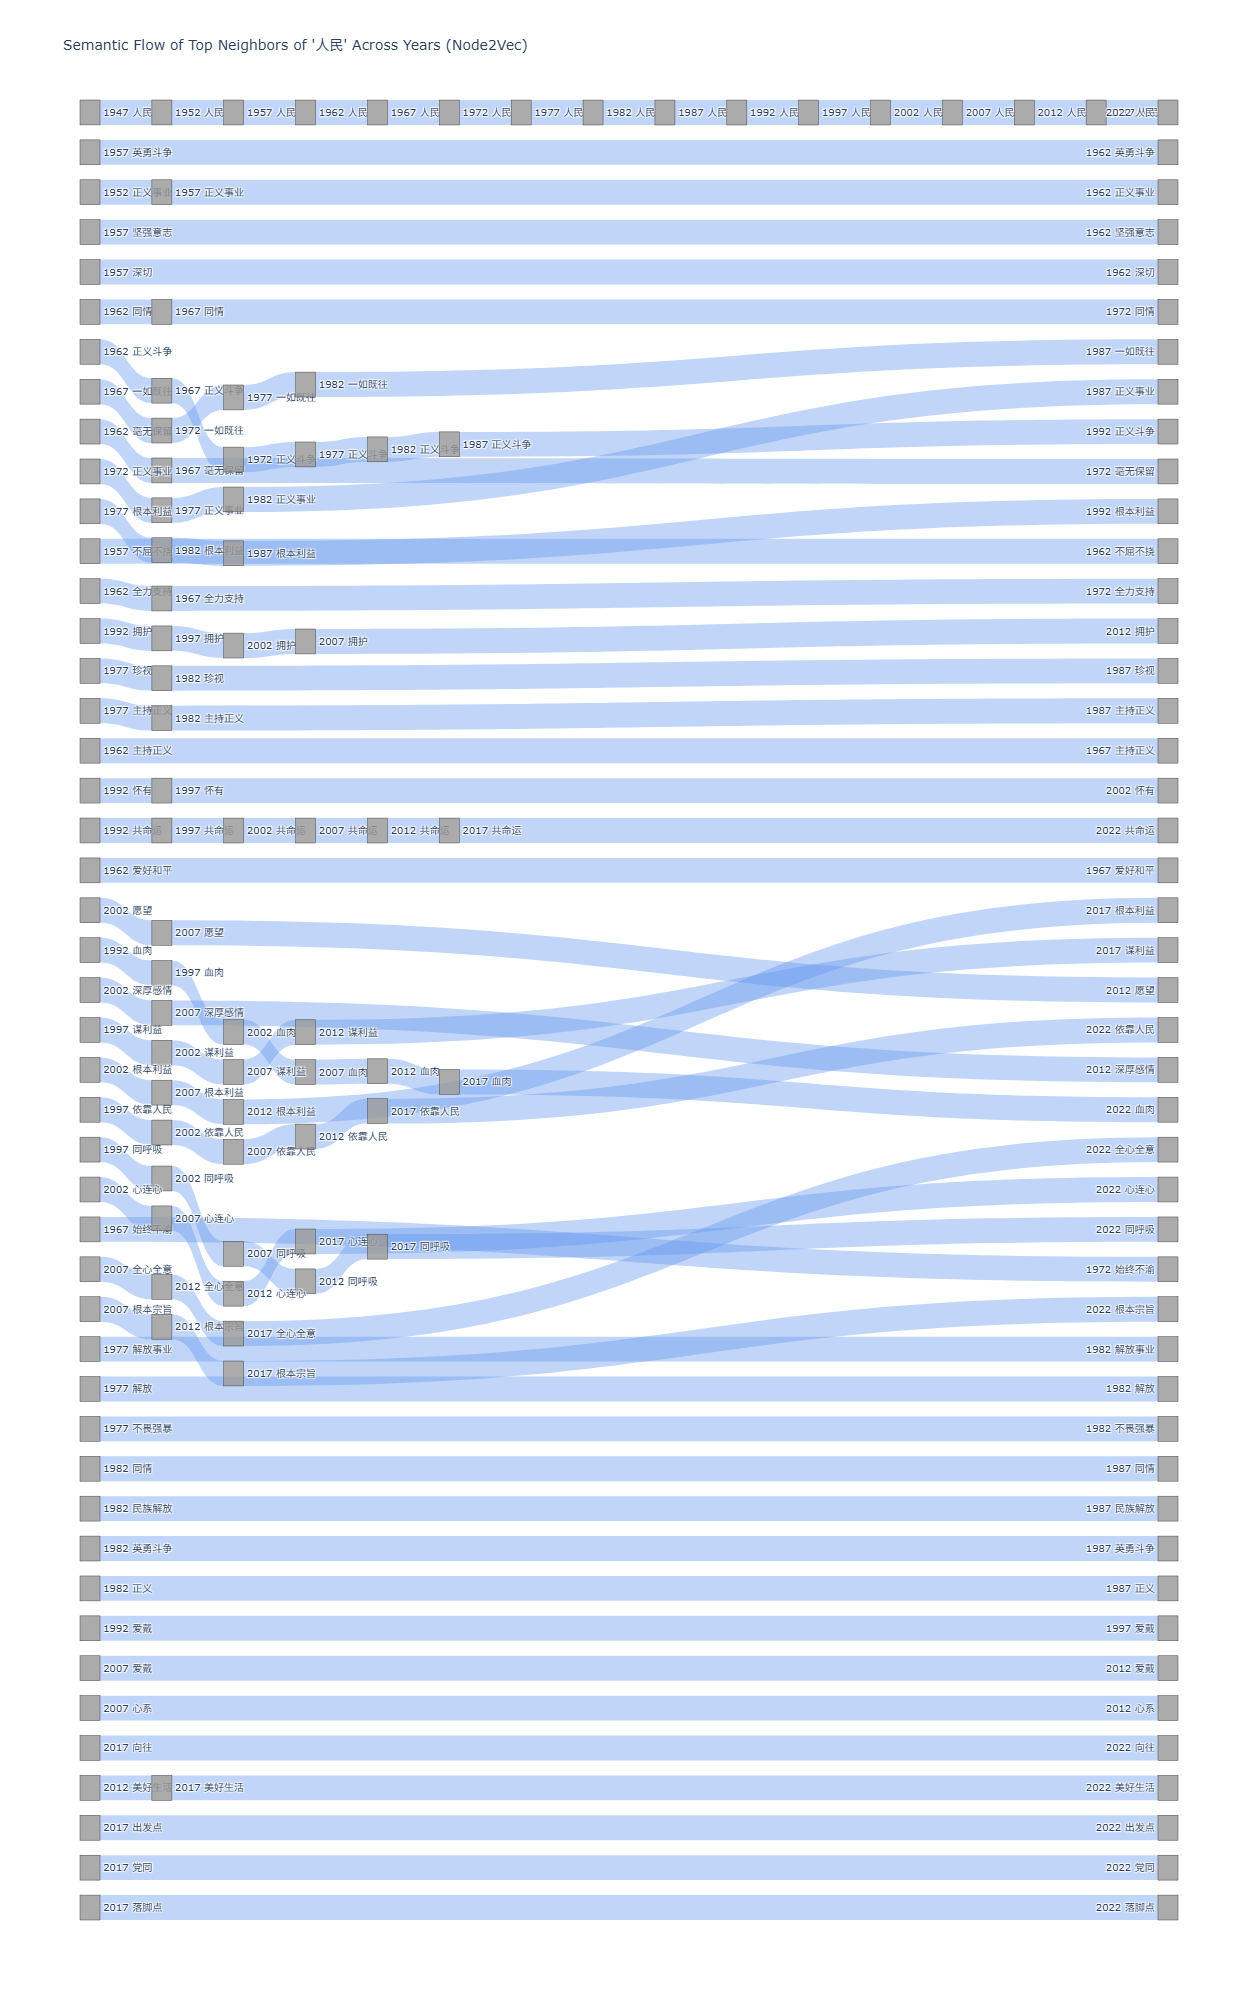

In [66]:
import pandas as pd
import plotly.graph_objects as go

# ---------- 1. Load data ----------
csv_path = "renmin_neighbors_node2vec.csv"  # change if needed
df = pd.read_csv(csv_path)

# Optional: only keep top-K neighbors per year
TOPK = 20
df = df[df["rank"] <= TOPK]

# Choose years you want to visualize (可以改成你想要的年份列表)
years_to_plot = [1947, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007, 2012, 2017, 2022]

df = df[df["year"].isin(years_to_plot)]

# ---------- 2. Build nodes: each (year, neighbor) pair is a node ----------
# Node label: "year\nneighbor"
df["node_label"] = df["year"].astype(str) + "\n" + df["neighbor"]

# Get unique nodes and assign indices
unique_nodes = df["node_label"].unique().tolist()
node_index = {label: i for i, label in enumerate(unique_nodes)}

# ---------- 3. Build links: connect same neighbor across consecutive years ----------
sources = []
targets = []
values = []

# We group by neighbor word, then see in哪些年份出现过
for neighbor, g in df.groupby("neighbor"):
    # 按年份排序
    g_sorted = g.sort_values("year")
    years_list = g_sorted["year"].tolist()
    labels_list = g_sorted["node_label"].tolist()
    sims_list = g_sorted["similarity"].tolist()

    # 在相邻年份之间画边
    for i in range(len(years_list) - 1):
        year1 = years_list[i]
        year2 = years_list[i + 1]
        label1 = labels_list[i]
        label2 = labels_list[i + 1]

        # 只连接真正相邻的时间点（防止中间缺一年跳过去）
        # 如果你不介意可以去掉这个判断
        idx1 = years_to_plot.index(year1)
        idx2 = years_to_plot.index(year2)
        if idx2 - idx1 != 1:
            # 中间隔了年份，可以视情况要不要连
            # 这里选择跳过不连
            continue

        src = node_index[label1]
        tgt = node_index[label2]

        # 可以用平均 similarity / 最小 similarity 做权重，这里简单用 1
        # 或者用两年 similarity 的平均值:
        # val = (sims_list[i] + sims_list[i+1]) / 2
        val = 1.0

        sources.append(src)
        targets.append(tgt)
        values.append(val)

# ---------- 4. Create Sankey diagram ----------
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(width=0.5),
        label=unique_nodes,
        color="rgba(150,150,150,0.8)"  # node color，可以自己改
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(100,149,237,0.4)"  # edge color，可改
    )
)])

fig.update_layout(
    title_text="Semantic Flow of Top Neighbors of '人民' Across Years (Node2Vec)",
    font=dict(size=10),
    width=1300,  
    height=2000
)

fig.show()


In [67]:
from networkx.algorithms import community

def detect_communities_and_get_target(G, target="人民"):
    """
    Run community detection on graph G and return:
      - comms: list of communities (each is a set of nodes)
      - node2comm: dict node -> community_id
      - target_comm_nodes: list of nodes in the same community as `target`
    """
    if G is None or G.number_of_nodes() == 0:
        return [], {}, []

    # 1) greedy modularity communities (undirected, weighted)
    comms = list(community.greedy_modularity_communities(G, weight="weight"))

    # 2) build node -> community id map
    node2comm = {}
    for cid, nodes in enumerate(comms):
        for n in nodes:
            node2comm[n] = cid

    # 3) find target community
    if target not in node2comm:
        target_comm_nodes = []
    else:
        target_cid = node2comm[target]
        target_comm_nodes = sorted(list(comms[target_cid]))

    return comms, node2comm, target_comm_nodes


In [68]:
# 假设你已经有 G_2000（build_semantic_graph_for_year 的输出）
comms_2000, node2comm_2000, renmin_comm_2000 = detect_communities_and_get_target(G_2000, target="人民")

print("Number of communities:", len(comms_2000))
print("Size of Renmin community:", len(renmin_comm_2000))
print("Sample of Renmin community nodes:", renmin_comm_2000[:50])


Number of communities: 8
Size of Renmin community: 864
Sample of Renmin community nodes: ['一中一台', '一代', '一代代', '一以贯之', '一国', '一国两制', '一种', '一脉相承', '万众一心', '三个代表', '三中全会', '三代', '三座大山', '三步走', '三通', '上层建筑', '不仅仅', '不可动摇', '不如说是', '不尽相同', '不屈', '不屈不挠', '不怕牺牲', '不愧为', '不懈', '不断丰富', '不断创新', '不断前进', '不断涌现', '不断进取', '不断进步', '不竭', '不能允许', '不负', '不辱使命', '与会同志', '与时俱进', '世俗', '世界大战', '世界观', '两岸人民', '两手', '个人主义', '中共中央', '中共中央国务院', '中华儿女', '中华民族', '中国共产党', '中心组', '丰功伟绩']


In [69]:
import pyspark.sql.functions as F

def add_community_labels_to_embeddings(n2v_df, node2comm):
    """
    Join community labels into Node2Vec embeddings DataFrame.
    Returns a new DataFrame with an extra column 'community'.
    """
    # convert dict -> Spark DataFrame
    mapping = [(w, int(cid)) for w, cid in node2comm.items()]
    comm_df = spark.createDataFrame(mapping, ["word", "community"])

    # left join on 'word'
    n2v_with_comm = (
        n2v_df
        .join(comm_df, on="word", how="left")
    )
    return n2v_with_comm


In [70]:
n2v_2000 = spark.read.parquet("node2vec_embeddings_concept/year=2000")

n2v_2000_with_comm = add_community_labels_to_embeddings(n2v_2000, node2comm_2000)

n2v_2000_with_comm.show(5, truncate=False)


+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [76]:
POLITICAL_VOCAB = [

    # Masses / People / Workers
    "人民","群众","工人","农民","干部","农民工","青年","妇女","大众","职工","工友","乡亲","同胞","同学",
    "居民","公民","党员","社员","劳动者","员工","退伍军人","志愿者","基层群众","基层干部",
    "教师","医务人员","学生","患者","老百姓","村民","市民","工人阶级","劳动阶级","群众代表",
    "人民群众","人民代表","人民团体","人民子弟兵","人民军队","人民教师","人民警察","人民公仆",

    # State / Government / Institutions
    "国家","政府","中央","地方","党委","党组织","基层党组织","党支部","中央政府","国务院","人大",
    "政协","党委书记","政府部门","组织部门","宣传部门","政法机关","司法机关","公检法","监察机关",
    "纪检部门","干部队伍","公务员","管理者","领导干部","人民政府","人民法院","人民检察院",
    "国家机关","国家部门","执法部门","行政机关","人民代表大会","社会主义国家","政权机关",

    # Political system: rule of law / elections / oversight
    "民主","法治","宪法","法律","法规","制度","体制","选举","监督","纪律","问责","监察",
    "审判","审查","立法","司法","执法","行政","改革","治理","权利","义务","平等","公开","透明",
    "监督权","表决权","参政议政","依法治国","依法行政","人民主权","人民当家作主","人大制度",
    "选举制度","政治参与","政治权利","法治政府","廉政","反腐","反腐败","依法办事","程序正义",
    "社会公正","国家治理体系","国家治理能力",

    # Development / Economy / Innovation
    "发展","建设","现代化","改革开放","创新","生产","经济","产业","投资","消费","市场","企业","劳动",
    "就业","脱贫","扶贫","民生","住房","教育","医疗","养老","交通","城镇化","乡村振兴","基础设施",
    "科技","数字化","信息化","高质量发展","可持续发展","经济增长","收入","分配","社会保障",
    "福利","公共服务","城乡建设","区域发展",

    # Ideology / Governance narrative
    "社会主义","共产主义","马克思主义","新时代","使命","责任","担当","奋斗","奉献","团结","自力更生",
    "共同富裕","民族复兴","民族团结","伟大事业","伟大斗争","伟大工程","伟大梦想","核心价值观",
    "人民立场","人民至上","以人民为中心","群众路线","初心","使命","信仰","信念","信心","制度优势",
    "集体主义","国家利益","社会稳定","国家安全","共同体","命运共同体","爱国","责任担当",

    # Security / Stability / Military
    "军队","武警","民兵","国防","安全","治安","维稳","反恐","救援","抢险","边防","公安","消防",
    "执勤","安保","防务"
]


In [77]:
def build_fixed_vocab_for_year(year: int):
    """
    Use a fixed political vocab across all years.
    Only keep words that exist in this year's Word2Vec vocab.
    """
    model_path = f"{BASE_MODEL_DIR}/year={year}"
    w2v_model = Word2VecModel.load(model_path)
    vecs_df = w2v_model.getVectors()

    vocab = (
        vecs_df
        .filter(F.col("word").isin(POLITICAL_VOCAB))
        .select("word")
        .rdd.map(lambda r: r["word"])
        .collect()
    )

    return sorted(vocab)


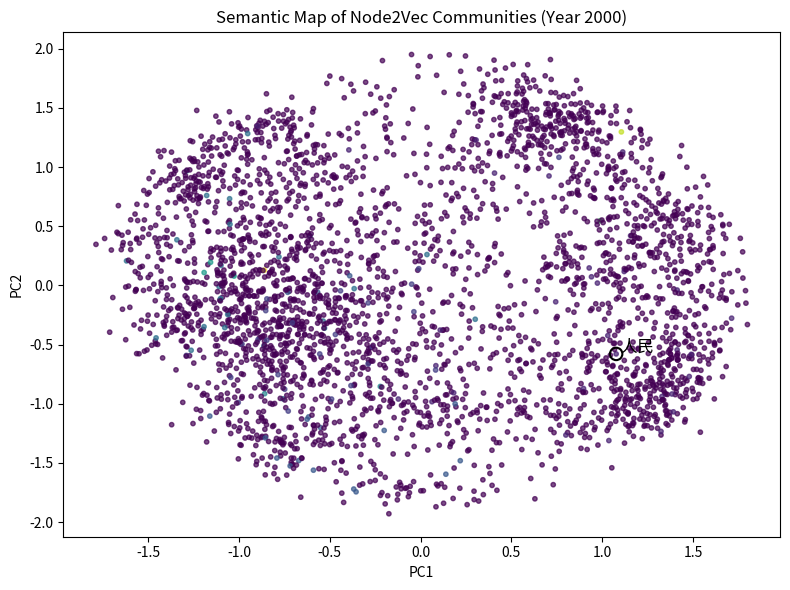

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---- 1. 指定年份 ----
YEAR = 2000  # 改成你想看的年份

# ---- 2. 读取这一年的图 G + 做社区检测 ----
# 如果你手头已经有 G_year，可以直接用；否则再建一次：
vocab_year = build_fixed_vocab_for_year(YEAR)
G_year, words_year = build_semantic_graph_for_year(YEAR, vocab_year)

comms, node2comm, renmin_comm_nodes = detect_communities_and_get_target(G_year, target="人民")

# ---- 3. 读取这一年的 Node2Vec 向量，并加上 community 标签 ----
n2v_df = spark.read.parquet(f"{N2V_OUT_BASE}/year={YEAR}")
n2v_with_comm = add_community_labels_to_embeddings(n2v_df, node2comm)

# 转成 pandas，准备做 PCA 和画图
pdf = n2v_with_comm.toPandas()

# 有些孤立点可能 community 是 NaN，先填一个默认值
pdf["community"] = pdf["community"].fillna(-1).astype(int)

# ---- 4. PCA 降维到 2D ----
X = np.vstack(pdf["n2v_vector"].values)  # shape: (N, dim)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X)

pdf["PC1"] = coords[:, 0]
pdf["PC2"] = coords[:, 1]

# ---- 5. 画图：按社区着色，并高亮“人民” ----
plt.figure(figsize=(8, 6))

# 普通节点：按 community 着色
scatter = plt.scatter(
    pdf["PC1"],
    pdf["PC2"],
    c=pdf["community"],
    s=10,
    alpha=0.7
)

# 高亮“人民”
mask_renmin = (pdf["word"] == "人民")
plt.scatter(
    pdf.loc[mask_renmin, "PC1"],
    pdf.loc[mask_renmin, "PC2"],
    s=80,
    edgecolors="black",
    facecolors="none",
    linewidths=1.5
)

# 给“人民”打标签
for _, row in pdf[mask_renmin].iterrows():
    plt.text(
        row["PC1"] + 0.02,
        row["PC2"] + 0.02,
        row["word"],
        fontsize=12,
        weight="bold"
    )

plt.title(f"Semantic Map of Node2Vec Communities (Year {YEAR})")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()
